In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Visualizing what convnets learn

This notebook contains the code sample found in Chapter 5, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

人们常说，深度学习模型是“黑盒”，即模型学到的表示很难用人类可以理解的方式来提取和呈现。虽然对于某些类型的深度学习模型来说，这种说法部分正确，但对卷积神经网络来说绝对不是这样。卷积神经网络学到的表示非常适合可视化，很大程度上是因为它们是视觉概念的表示。自 2013 年以来，人们开发了多种技术来对这些表示进行可视化和解释。我们不会在书中全部介绍，但会介绍三种最容易理解也最有用的方法。

* 可视化卷积神经网络的中间输出（中间激活）：有助于理解卷积神经网络连续的层如何对输入进行变换，也有助于初步了解卷积神经网络每个过滤器的含义。
* 可视化卷积神经网络的过滤器：有助于精确理解卷积神经网络中每个过滤器容易接受的视觉模式或视觉概念。
* 可视化图像中类激活的热力图：有助于理解图像的哪个部分被识别为属于某个类别，从而可以定位图像中的物体。

对于第一种方法（即激活的可视化），我们将使用 5.2 节在猫狗分类问题上从头开始训练的小型卷积神经网络。对于另外两种可视化方法，我们将使用 5.3 节介绍的 VGG16 模型。

## Visualizing intermediate activations

可视化中间激活，是指对于给定输入，展示网络中各个卷积层和池化层输出的特征图（层的输出通常被称为该层的激活，即激活函数的输出）。这让我们可以看到输入如何被分解为网络 学到的不同过滤器。我们希望在三个维度对特征图进行可视化：宽度、高度和深度（通道）。每个通道都对应相对独立的特征，所以将这些特征图可视化的正确方法是将每个通道的内容分别绘制成二维图像。

我们首先来加载 5.2 节保存的模型。

In [0]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_ys_2.h5')
model.summary()  # As a reminder.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

接下来，我们需要一张输入图像，即一张猫的图像，它不属于网络的训练图像。

In [0]:
img_path = 'cats_and_dogs_small/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
# 请记住，训练模型的输入数据都用这种方法预处理
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Let's display our picture:

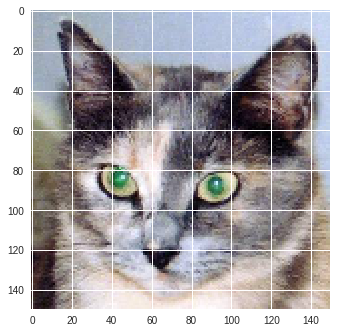

In [0]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

为了提取想要查看的特征图，我们需要创建一个 Keras 模型，以图像批量作为输入，并输出 所有卷积层和池化层的激活。为此，我们需要使用 Keras 的 Model 类。模型实例化需要两个参数：一个输入张量（或输入张量的列表）和一个输出张量（或输出张量的列表）。得到的类是一个 Keras 模型，就像你熟悉的 Sequential 模型一样，将特定输入映射为特定输出。Model 类允许模型有多个输出，这一点与 Sequential 模型不同。想了解 Model 类的更多信息，请参见 7.1 节。

In [0]:
from keras import models

# Extracts the outputs of the top 8 layers:（提取前 8 层的输出）
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:创建一个模型，给定模型输入， 可以返回这些输出）
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

输入一张图像，这个模型将返回原始模型前 8 层的激活值。这是你在本书中第一次遇到的多输出模型，之前的模型都是只有一个输入和一个输出。一般情况下，模型可以有任意个输入和输出。这个模型有一个输入和 8 个输出，即每层激活对应一个输出。

In [0]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

例如，这是我们猫图像输入的第一个卷积层的激活：

In [0]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


它是大小为 148×148 的特征图，有 32 个通道。我们来绘制原始模型第一层激活的第 3 个通道

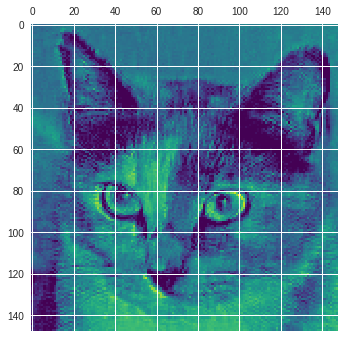

In [0]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

这个通道似乎是对角边缘检测器。我们再看一下第 30 个通道（见下图）。但请注意，你的通道可能与此不同，因为卷积层学到的过滤器并不是确定的。

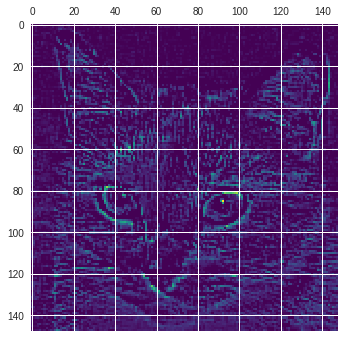

In [0]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

这个通道看起来像是“鲜绿色圆点”检测器，对寻找猫眼睛很有用。下面我们来绘制网络中所有激活的完整可视化（见上图）。我们需要在 8 个特征图中的每一个中提取并绘制每一个通道，然后将结果叠加在一个大的图像张量中，按通道并排。

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


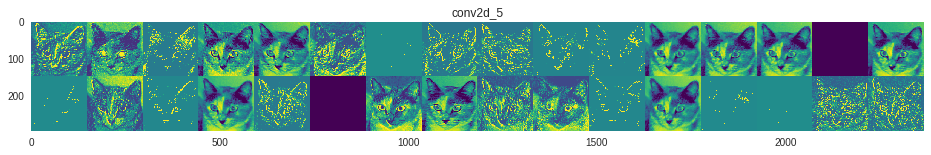

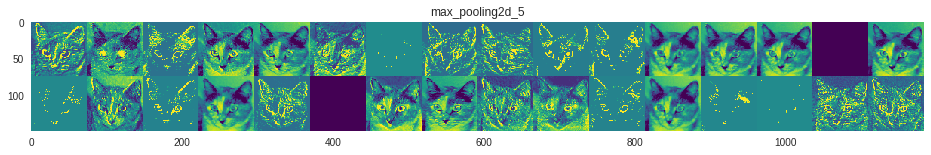

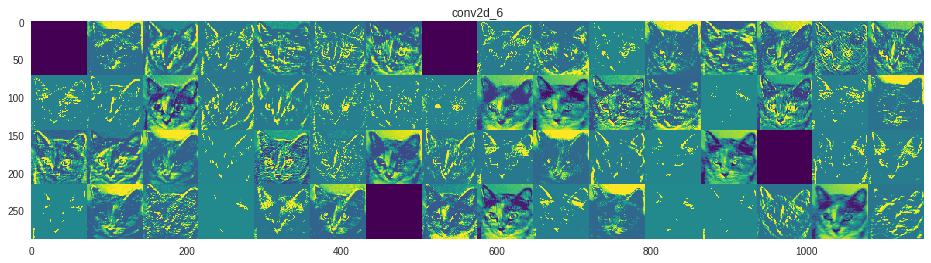

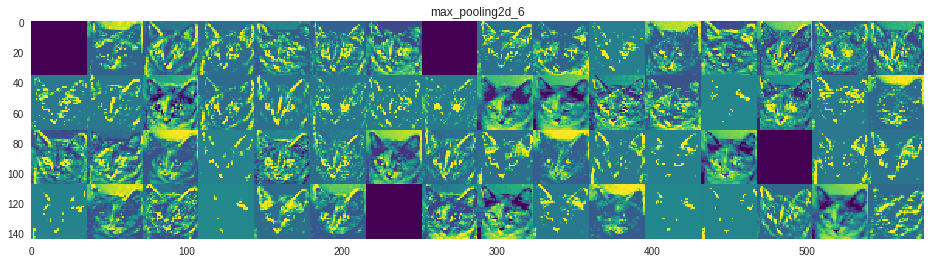

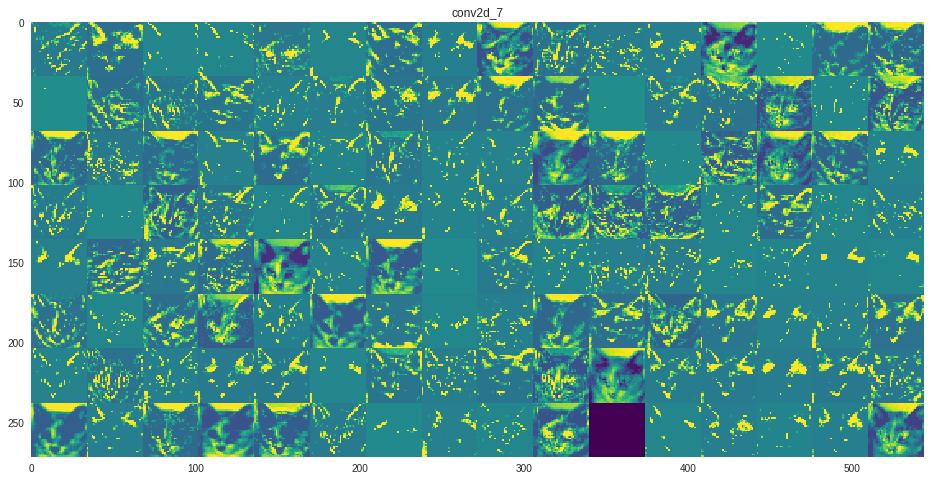

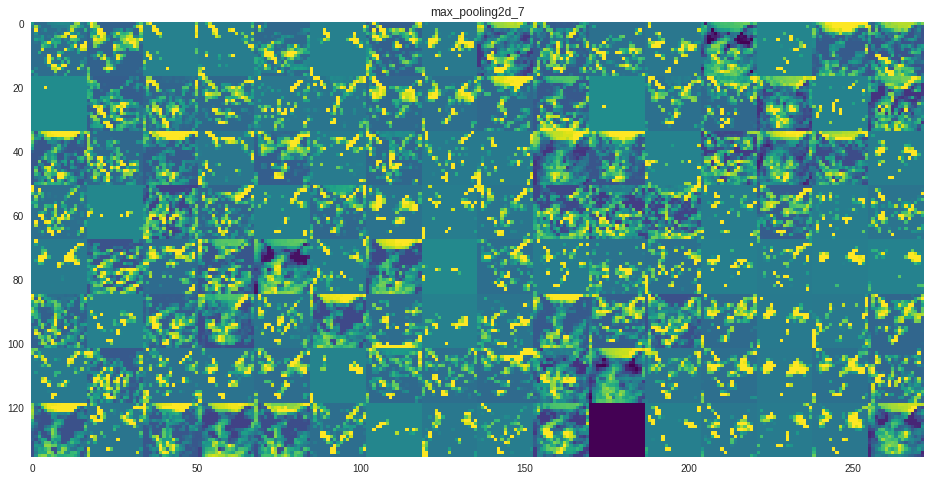

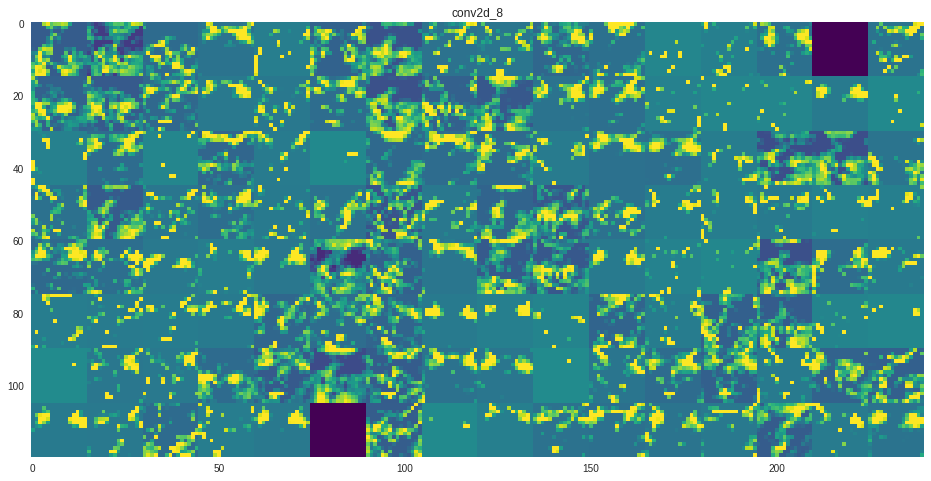

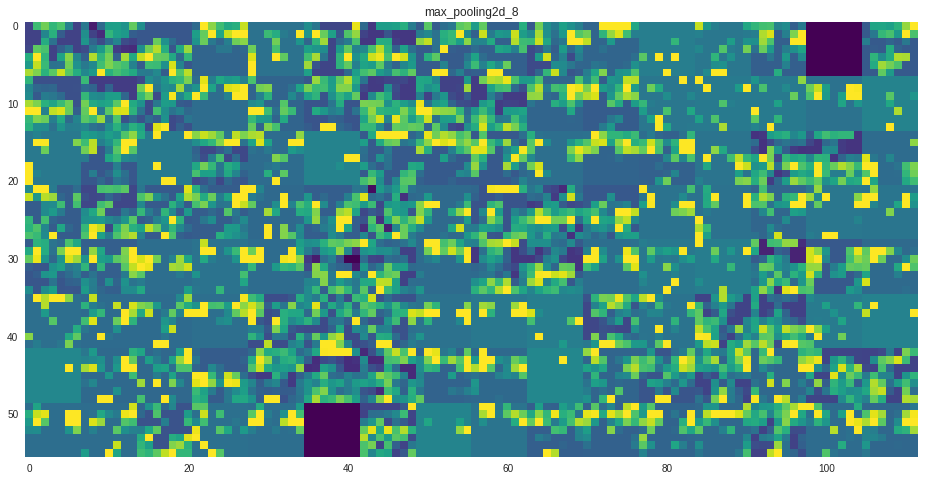

In [0]:
import keras

# These are the names of the layers, so can have them as part of our plot
# 层的名称，这样你可以将这些名称画到图中
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps（显示特征图）
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map（特征图中的特征个数）
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
#     特征图的形状为 (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
#     在这个矩阵中将激活通道平铺
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
#     将每个过滤器平铺到一个大的水平网格中
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            # 对特征进行后 处理，使其看 起来更美观
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid（显示网格）
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

这里需要注意以下几点。

* 第一层是各种边缘探测器的集合。在这一阶段，激活几乎保留了原始图像中的所有信息。
* 随着层数的加深，激活变得越来越抽象，并且越来越难以直观地理解。它们开始表示更高层次的概念，比如“猫耳朵”和“猫眼睛”。层数越深，其表示中关于图像视觉内容的信息就越少，而关于类别的信息就越多。
* 激活的稀疏度（sparsity）随着层数的加深而增大。在第一层里，所有过滤器都被输入图像激活，但在后面的层里，越来越多的过滤器是空白的。也就是说，输入图像中找不到这些过滤器所编码的模式。

我们刚刚揭示了深度神经网络学到的表示的一个重要普遍特征：随着层数的加深，层所提取的特征变得越来越抽象。更高的层激活包含关于特定输入的信息越来越少，而关于目标的信息越来越多（本例中即图像的类别：猫或狗）。深度神经网络可以有效地作为信息蒸馏管道（information distillation pipeline），输入原始数据（本例中是 RGB 图像），反复对其进行变换， 将无关信息过滤掉（比如图像的具体外观），并放大和细化有用的信息（比如图像的类别）。

这与人类和动物感知世界的方式类似：人类观察一个场景几秒钟后，可以记住其中有哪些 抽象物体（比如自行车、树），但记不住这些物体的具体外观。事实上，如果你试着凭记忆画一辆普通自行车，那么很可能完全画不出真实的样子，虽然你一生中见过上千辆自行车（见 图 5-28）。你可以现在就试着画一下，这个说法绝对是真实的。你的大脑已经学会将视觉输入完全抽象化，即将其转换为更高层次的视觉概念，同时过滤掉不相关的视觉细节，这使得大脑很难记住周围事物的外观。

## Visualizing convnet filters


想要观察卷积神经网络学到的过滤器，另一种简单的方法是显示每个过滤器所响应的视觉模式。这可以通过在输入空间中进行梯度上升来实现：从空白输入图像开始，将梯度下降应用于卷积神经网络输入图像的值，其目的是让某个过滤器的响应最大化。得到的输入图像是选定 过滤器具有最大响应的图像。

这个过程很简单：我们需要构建一个损失函数，其目的是让某个卷积层的某个过滤器的值最大化；然后，我们要使用随机梯度下降来调节输入图像的值，以便让这个激活值最大化。例如， 对于在ImageNet 上预训练的 VGG16 网络，其 block3_conv1层第 0 个过滤器激活的损失如下所示：

In [0]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

58892288/58889256 [==============================] - 1s 0us/step


为了实现梯度下降，我们需要得到损失相对于模型输入的梯度。为此，我们需要使用 Keras的 backend 模块内置的 gradients 函数

In [0]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
# 调用 gradients 返回的是一个张量列表（本例中列表长度为 1）。因此，只保留第一个元素，它是一个张量

grads = K.gradients(loss, model.input)[0]

为了让梯度下降过程顺利进行，一个非显而易见的技巧是将梯度张量除以其 L2 范数（张量 中所有值的平方的平均值的平方根）来标准化。这就确保了输入图像的更新大小始终位于相同的范围。

In [0]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

现在你需要一种方法：给定输入图像，它能够计算损失张量和梯度张量的值。你可以定义一个 Keras 后端函数来实现此方法：iterate 是一个函数，它将一个 Numpy 张量（表示为长度 为 1 的张量列表）转换为两个 Numpy 张量组成的列表，这两个张量分别是损失值和梯度值。

In [0]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

现在你可以定义一个 Python 循环来进行随机梯度下降。

In [0]:
# We start from a gray image with some noise（从一张带有噪声的 灰度图像开始）
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps（运行 40 次梯度上升）
step = 1.  # this is the magnitude of each gradient update（每次梯度更新的步长）
for i in range(40):
    # Compute the loss value and gradient value（计算损失值和梯度值）
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
#  沿着让损失最大化的 方向调节输入图像   
    input_img_data += grads_value * step

得到的图像张量是形状为 (1, 150, 150, 3) 的浮点数张量，其取值可能不是 [0, 255] 区间内的整数。因此，你需要对这个张量进行后处理，将其转换为可显示的图像。下面这个简单的实用函数可以做到这一点。

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    #     对张量做标准化，使其均值为 0， 标准差为 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    # clip to [0, 1]（将 x 裁切（clip）到 [0, 1] 区间）
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array （将 x 转换为 RGB 数组）
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

接下来，我们将上述代码片段放到一个 Python 函数中，输入一个层的名称和一个过滤器索引，它将返回一个有效的图像张量，表示能够将特定过滤器的激活最大化的模式。

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

Let's try this:

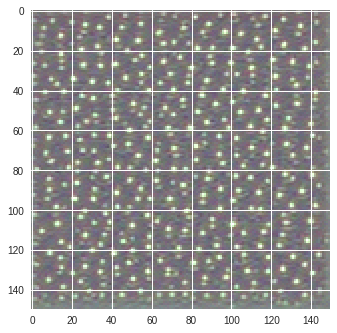

In [0]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

看起来，block3_conv1 层第 0 个过滤器响应的是波尔卡点（polka-dot）图案。

下面来看有趣的部分：我们可以将每一层的每个过滤器都可视化。为了简单起见，我们只查看每一层的前 64 个过滤器，并只查看每个卷积块的第一层（即 block1_conv1、block2_conv1、block3_conv1、block4_ conv1、block5_conv1）。我们将输出放在一个 8×8 的网格中， 每个网格是一个 64 像 素×64 像素的过滤器模式，两个过滤器模式之间留有一些黑边（见上图）。

In [19]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

这些过滤器可视化包含卷积神经网络的层如何观察世界的很多信息：卷积神经网络中每一层都学习一组过滤器，以便将其输入表示为过滤器的组合。这类似于傅里叶变换将信号分解为一 组余弦函数的过程。随着层数的加深，卷积神经网络中的过滤器变得越来越复杂，越来越精细。

* 模型第一层（block1_conv1）的过滤器对应简单的方向边缘和颜色（还有一些是彩色边缘）。
* block2_conv1 层的过滤器对应边缘和颜色组合而成的简单纹理。
* 更高层的过滤器类似于自然图像中的纹理：羽毛、眼睛、树叶等。

## Visualizing heatmaps of class activation

我还要介绍另一种可视化方法，它有助于了解一张图像的哪一部分让卷积神经网络做出了最终的分类决策。这有助于对卷积神经网络的决策过程进行调试，特别是出现分类错误的情况下。 这种方法还可以定位图像中的特定目标。

这种通用的技术叫作类激活图（CAM，class activation map）可视化，它是指对输入图像生成类激活的热力图。类激活热力图是与特定输出类别相关的二维分数网格，对任何输入图像的每个位置都要进行计算，它表示每个位置对该类别的重要程度。举例来说，对于输入到猫狗分 类卷积神经网络的一张图像，CAM可视化可以生成类别“猫”的热力图，表示图像的各个部分与“猫”的相似程度，CAM 可视化也会生成类别“狗”的热力图，表示图像的各个部分与“狗”的相似程度。

我们将使用的具体实现方式是“Grad-CAM: visual explanations from deep networks via gradient- based localization”a 这篇论文中描述的方法。这种方法非常简单：给定一张输入图像，对于一个卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权。直观上来看，理解这个技巧的一种方法是，你是用“每个通道对类别的重要程度”对“输入图像对不同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图。

我们再次使用预训练的 VGG16 网络来演示此方法。

In [20]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
# 注意，网络中包括了密集连接分类器。在前面所有的例子中，我们都舍弃了这个分类器
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 7s 0us/step


下图显示了两只非洲象的图像（遵守知识共享许可协议），可能是一只母象和它的小象，它们在大草原上漫步。

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

我们将这张图像转换为 VGG16 模型能够读取的格式：模型在大小为224×224 的图像上进行训练，这些训练图像都根据 keras.applications.vgg16.preprocess_ input 函数中内置的规则进行预处理。因此，我们需要加载图像，将其大小调整为 224×224， 然后将其转换为 float32 格式的 Numpy 张量，并应用这些预处理规则。

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [22]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 1us/step
Predicted: [('n02504458', 'African_elephant', 0.9094207), ('n01871265', 'tusker', 0.08618318), ('n02504013', 'Indian_elephant', 0.0043545896)]



对这张图像预测的前三个类别分别为：

* 非洲象（African elephant，90.9% 的概率）
* 长牙动物（tusker，8.6% 的概率）
* 印度象（Indian elephant，0.4% 的概率） 网络识别出图像中包含数量不确定的非洲象。
预测向量中被最大激活的元素是对应“非洲象”类别的元素，索引编号为 386。

In [23]:
np.argmax(preds[0])

386

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [0]:
# This is the "african elephant" entry in the prediction vector
# 预测向量中的“非洲象”元素
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
# block5_conv3 层的输出特征图，它是VGG16的最后一个卷积层
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
# “非洲象”类别相对于 block5_conv3输出特征图的梯度

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel

# 形状为 (512,) 的向量，每个元素是特定特征图通道的梯度平均大小
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image

# 访问刚刚定义的量：对于给定的样本图像，pooled_grads 和 block5_conv3 层的输出特征图

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
# 对于两个大象的样本图像， 这两个量都是 Numpy 数组
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
# 将特征图数组的每个 通道乘以“这个通道 对‘大象’类别的重要程度”
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
# 得到的特征图的逐通道平均值即为类激活的热力图

heatmap = np.mean(conv_layer_output_value, axis=-1)

为了便于可视化，我们还需要将热力图标准化到 0~1 范围内。

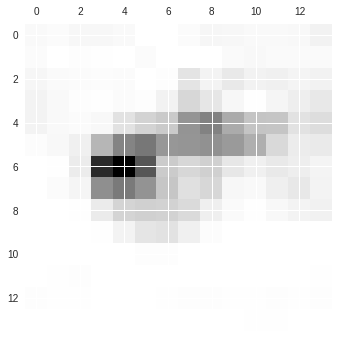

In [25]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

最后，我们可以用 OpenCV 来生成一张图像，将原始图像叠加在刚刚得到的热力图上

In [27]:
import cv2

# We use cv2 to load the original image（用 cv2 加载原始图像）
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
# 将热力图的大小调整 为与原始图像相同
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB（将热力图转换为 RGB 格式）
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image（将热力图应用于原始图像）
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor（这里的 0.4 是热力图强度因子）
superimposed_img = heatmap * 0.4 + img

# Save the image to disk（将图像保存到硬盘）
cv2.imwrite('elephant_cam_ys.jpg', superimposed_img)

True

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

这种可视化方法回答了两个重要问题：

* 网络为什么会认为这张图像中包含一头非洲象？
* 非洲象在图像中的什么位置？ 

尤其值得注意的是，小象耳朵的激活强度很大，这可能是网络找到的非洲象和印度象的不同之处。
